<h1 align="center">Recurrent Neural Networks</h1>

## Integrantes

- Josué Say
- Andre Jo

## Repositorio

- [Enlace a GitHub](https://github.com/JosueSay/labs_dl/tree/main/lab4)
- [Documentación sobre RNN y dataset Sunspots](https://github.com/JosueSay/labs_dl/blob/main/lab4/docs/investigacion.md)

In [65]:
# %pip install -r requirements.txt

## Librerias y Constantes

In [66]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

Cargamos primero el archivo csv y normalizamos los valores de la mancha de los soles. 

In [67]:
# Configuración general
DATA_PATH = "sunspot.csv"
SEPARATOR = ";"
RANDOM_SEED = 42
LR = 1e-2
EPOCHS = 50
HIDDEN_SIZE = 16
WINDOWS = {"initial": 10, "small": 5, "medium": 20, "large": 100}

# Semillas para reproducibilidad
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Carga y esquema de columnas

Se lee el archivo CSV oficial del **Sunspot Index and Long-term Solar Observations (SILSO/SIDC)** en su versión diaria v2.0.  
El dataset está separado por `;` y no incluye encabezados, por lo que se asignan nombres manualmente a las 8 columnas según la documentación oficial:

1. **year** -> Año de la observación.  
2. **month** -> Mes de la observación.  
3. **day** -> Día de la observación.  
4. **decimal_date** -> Fecha en formato decimal (ej. 2000.5 ≈ mitad del año 2000).  
5. **sunspot** -> Número diario de manchas solares (puede ser -1 si falta el dato).  
6. **std** -> Desviación estándar asociada al valor.  
7. **n_obs** -> Número de observaciones disponibles ese día.  
8. **flag_def** -> Indicador de método/definición usada para calcular el valor.  

In [68]:
def loadCsv(path):
    # Esquema CSV SIDC diario v2.0: 8 columnas separadas por ';'
    cols = ["year","month","day","decimal_date","sunspot","std","n_obs","flag_def"]
    df = pd.read_csv(path, sep=SEPARATOR, header=None, names=cols)
    return df

data = loadCsv(DATA_PATH)
data.head()

,year,month,day,decimal_date,sunspot,std,n_obs,flag_def
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


## Limpieza de faltantes

En el dataset, los valores de manchas solares faltantes están codificados con **-1** en la columna `sunspot`.  
Estos valores no representan observaciones reales, por lo que deben ser tratados antes de entrenar modelos.  

La estrategia utilizada es eliminación de filas:
- Se filtran todas las observaciones con `sunspot >= 0`.  
- Se descartan las filas con `sunspot == -1`.  
- Se reinicia el índice del DataFrame para mantener la secuencia continua.  

In [69]:
def dropMissingSunspots(df):
    return df[df["sunspot"] >= 0].reset_index(drop=True)

data_clean = dropMissingSunspots(data)

## Índice de fecha y visualización inicial

Antes de entrenar modelos, se construye un índice temporal y se generan visualizaciones descriptivas.

1. **Construcción de índice de fechas**
   - Se combinan las columnas `year`, `month` y `day` en un objeto `datetime`.  
   - Se eliminan filas con fechas inválidas.  
   - Se establece la columna `date` como índice y se ordena cronológicamente.  

2. **Visualización 1: Serie diaria completa**
   - Gráfico de la evolución del **Sunspot Number diario** en toda la serie.  
   - Permite observar la variabilidad a corto plazo y los ciclos solares (~11 años).  

3. **Visualización 2: Promedio mensual**
   - Se aplica un **resampleo mensual** calculando el promedio por mes.  
   - El resultado suaviza la alta variabilidad diaria, facilitando la identificación de tendencias a mediano y largo plazo.  

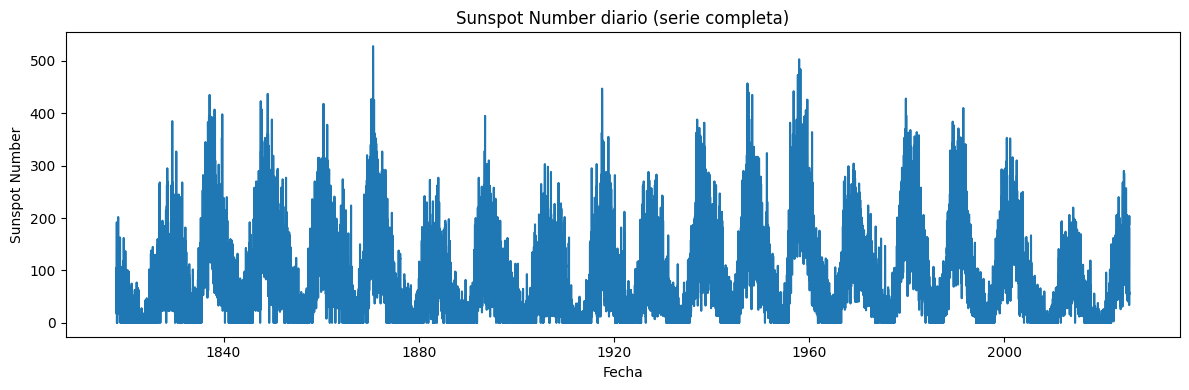

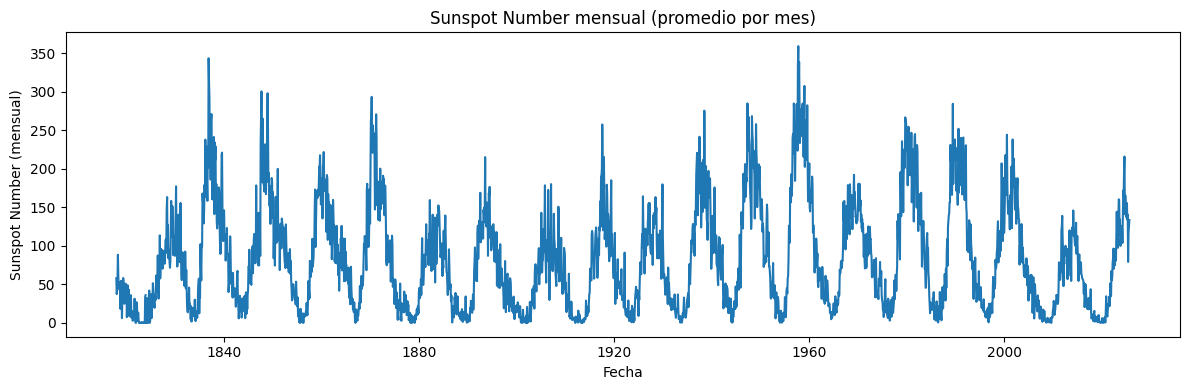

In [70]:
def visualizarSerieCompleta(df):
    # Espera un DataFrame limpio (sin -1 en 'sunspot') con columnas: year, month, day, sunspot
    dfx = df.copy()
    dfx["date"] = pd.to_datetime(
        dict(year=dfx["year"], month=dfx["month"], day=dfx["day"]),
        errors="coerce"
    )
    dfx = dfx[dfx["date"].notna()].set_index("date").sort_index()

    # Gráfica 1: serie diaria completa
    plt.figure(figsize=(12,4))
    plt.plot(dfx.index, dfx["sunspot"])
    plt.title("Sunspot Number diario (serie completa)")
    plt.xlabel("Fecha"); plt.ylabel("Sunspot Number")
    plt.tight_layout()
    plt.show()

    # Gráfica 2: promedio mensual (suaviza la variabilidad diaria)
    monthly = dfx["sunspot"].resample("MS").mean()
    plt.figure(figsize=(12,4))
    plt.plot(monthly.index, monthly.values)
    plt.title("Sunspot Number mensual (promedio por mes)")
    plt.xlabel("Fecha"); plt.ylabel("Sunspot Number (mensual)")
    plt.tight_layout()
    plt.show()

visualizarSerieCompleta(data_clean)

## Partición temporal

Dado que los datos corresponden a una **serie temporal** (valores diarios de manchas solares), no se pueden mezclar de forma aleatoria como en otros problemas de machine learning.  
Para mantener la coherencia temporal y evitar fuga de información, se divide el dataset de forma secuencial:

1. **Entrenamiento (70%)** -> Primer bloque de observaciones, usado para ajustar los parámetros del modelo.  
2. **Validación (15%)** -> Bloque intermedio, utilizado para ajustar hiperparámetros y prevenir sobreajuste.  
3. **Prueba (15%)** -> Último bloque, reservado exclusivamente para evaluar el desempeño final del modelo en datos no vistos.  

La función `splitTemporal` recibe proporciones de partición y retorna tres subconjuntos (`train`, `val`, `test`) garantizando que siempre se respete el orden cronológico original de la serie.

In [71]:
def splitTemporal(df, train_ratio=0.7, val_ratio=0.15):
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train = df.iloc[:n_train].copy()
    val   = df.iloc[n_train:n_train+n_val].copy()
    test  = df.iloc[n_train+n_val:].copy()
    return train, val, test

train_df, val_df, test_df = splitTemporal(data_clean)

## Normalización

En este caso, se utiliza una **normalización Min-Max**:

1. **Ajuste del escalador (`fitScaler`)**  
   - Se calcula el valor mínimo y máximo de la serie únicamente en el conjunto de entrenamiento.
   - Esto evita data leakage (fuga de información del futuro hacia el pasado).  

2. **Aplicación del escalador (`applyScaler`)**  
   - Cada valor de la serie se transforma a:  
     $$
     x' = \frac{x - \text{min}}{\text{max} - \text{min}}
     $$
   - Resultado: todos los valores quedan en el rango **[0, 1]**.  

3. **Uso en todos los conjuntos**  
   - Se aplica la misma transformación (con min y max del *train*) sobre validación y prueba.  
   - Así se asegura consistencia en la escala entre datasets.  

Se agregan nuevas columnas `sunspot_norm` en `train_df`, `val_df` y `test_df` que contienen los valores normalizados.

In [72]:
def fitScaler(train_series):
    min_v = float(train_series.min())
    max_v = float(train_series.max())
    return {"min": min_v, "max": max_v}

def applyScaler(series, scaler):
    return (series - scaler["min"]) / (scaler["max"] - scaler["min"] + 1e-12)


scaler = fitScaler(train_df["sunspot"])
train_df["sunspot_norm"] = applyScaler(train_df["sunspot"], scaler)
val_df["sunspot_norm"]   = applyScaler(val_df["sunspot"], scaler)
test_df["sunspot_norm"]  = applyScaler(test_df["sunspot"], scaler)

## Ventaneo

Para entrenar una RNN en series temporales se transforma la serie original en subsecuencias de longitud fija que sirvan como entradas, junto con el valor inmediatamente siguiente como objetivo.

1. **Función `createSequences`**  
   - Recorre la serie normalizada creando pares `(X, y)`:
     - `X`: una ventana de tamaño fijo `seq_length`.  
     - `y`: el valor que sigue inmediatamente después de esa ventana.  
   - Convierte las secuencias a tensores PyTorch con dimensiones:  
     - `X`: `[batch_size, seq_length, 1]`  
     - `y`: `[batch_size, 1]`  

2. **Función `makeSplitsForSeq`**  
   - Aplica `createSequences` a los tres subconjuntos (`train`, `val`, `test`).  
   - Retorna las secuencias listas para alimentar a la RNN en cada fase del entrenamiento.  

De esta forma, la red aprende a predecir el siguiente valor de manchas solares a partir de los valores de los últimos `seq_length` días.


In [73]:
def createSequences(array_1d, seq_length):
    xs, ys = [], []
    for i in range(len(array_1d) - seq_length):
        x = array_1d[i:i+seq_length]
        y = array_1d[i+seq_length]
        xs.append(x)
        ys.append(y)
    X = torch.tensor(np.stack(xs), dtype=torch.float32).unsqueeze(-1)  # [batch, seq_len, 1]
    y = torch.tensor(np.stack(ys), dtype=torch.float32).unsqueeze(-1)  # [batch, 1]
    return X, y

def makeSplitsForSeq(df_train, df_val, df_test, seq_length):
    Xtr, ytr = createSequences(df_train["sunspot_norm"].values, seq_length)
    Xva, yva = createSequences(df_val["sunspot_norm"].values, seq_length)
    Xte, yte = createSequences(df_test["sunspot_norm"].values, seq_length)
    return (Xtr, ytr), (Xva, yva), (Xte, yte)

## Modelo RNN

Se define una red neuronal recurrente básica en PyTorch para predecir valores futuros de la serie de manchas solares.

1. **Clase `RnnModel`**
   - **Entrada:** secuencias de dimensión `[batch_size, seq_length, input_size]`.  
   - **Capa recurrente (`nn.RNN`):**
     - `input_size=1` → solo se ingresa una característica por paso temporal (el valor normalizado de manchas solares).  
     - `hidden_size=HIDDEN_SIZE` → número de unidades ocultas que capturan la dinámica temporal.  
     - `batch_first=True` → asegura que la dimensión de batch sea la primera (formato `[batch, seq_len, features]`).  
   - **Capa densa (`nn.Linear`):**
     - Recibe la representación oculta del último paso de la secuencia.  
     - Produce una salida escalar (`output_size=1`), correspondiente al valor predicho del siguiente día.  

2. **Método `forward`**
   - Pasa la secuencia completa por la capa RNN, obteniendo salidas para cada paso temporal.  
   - Selecciona la salida del **último paso temporal** (`out[:, -1, :]`) como resumen de la ventana.  
   - Pasa este vector por la capa fully connected (`fc`) para generar la predicción final.  

In [74]:
class RnnModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc  = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)             # out: [batch, seq_len, hidden]
        out = out[:, -1, :]              # último paso temporal
        out = self.fc(out)               # [batch, output_size]
        return out

## Experimentos por tamaño de ventana

El objetivo es comparar el desempeño de la RNN al entrenar con diferentes longitudes de ventana temporal.
Para ello, se definen dos funciones principales:

1. **Entrenamiento (`trainOneSplit`)**
   - Configura la función de pérdida **MSE (Error Cuadrático Medio)** y el optimizador **Adam**.  
   - Ciclo de entrenamiento:
     - Modo entrenamiento: realiza forward pass, calcula la pérdida de entrenamiento, retropropaga gradientes y actualiza parámetros.  
     - Monitorea la **norma de gradiente (`grad_norm`)** para detectar problemas de *vanishing* o *exploding gradients*.  
     - Modo validación: evalúa la pérdida en el conjunto de validación sin actualizar parámetros.  
   - Registra en `history` tuplas de la forma `(train_loss, val_loss, grad_norm)` por cada época.  
   - Muestra avances cada 10 épocas con métricas de entrenamiento, validación y norma de gradiente.  
   - Devuelve además el **tiempo total de entrenamiento** (`train_time`), calculado con `time.time()`.

2. **Evaluación (`evaluateModel`)**
   - Cambia a modo evaluación (`model.eval()`).  
   - Calcula las predicciones sobre el conjunto de prueba.  
   - Devuelve:
     - Predicciones como arreglo NumPy.  
     - Valores reales de prueba.  
     - MSE final sobre el conjunto de prueba.  

In [75]:
def trainOneSplit(model, Xtr, ytr, Xva, yva, epochs=EPOCHS, lr=LR):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = []
    start_time = time.time()

    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        preds = model(Xtr)
        loss = criterion(preds, ytr)
        loss.backward()

        # Norma del gradiente (para monitorear vanishing/exploding)
        grad_norm = torch.nn.utils.clip_grad_norm_((
            p for p in model.parameters() if p.grad is not None
        ), max_norm=float('inf')).item()

        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(Xva), yva).item()

        history.append((loss.item(), val_loss, grad_norm))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | train MSE={loss.item():.6f} "
                  f"| val MSE={val_loss:.6f} | grad_norm={grad_norm:.3f}")

    train_time = time.time() - start_time
    return history, train_time

def evaluateModel(model, Xte, yte):
    model.eval()
    with torch.no_grad():
        preds = model(Xte)
        mse = nn.MSELoss()(preds, yte).item()
    return preds.squeeze(-1).numpy(), yte.squeeze(-1).numpy(), mse


## Experimentos por tamaño de ventana

Se ejecutan experimentos completos con diferentes longitudes de ventana (`5`, `10`, `20`, `100`) para observar cómo afecta el historial de datos usado a la capacidad predictiva de la RNN.

1. **Función `runExperiment`**
   - **Preparación de datos:** genera los tensores de entrada/salida para entrenamiento, validación y prueba a partir del tamaño de ventana (`seq_length`).  
   - **Definición del modelo:** instancia un `RnnModel` con los parámetros establecidos.  
   - **Entrenamiento:** entrena el modelo con `trainOneSplit`, obteniendo:
     - El historial de entrenamiento `(train_loss, val_loss, grad_norm)` por época.  
     - El tiempo total de entrenamiento (`train_time`).  
   - **Evaluación:** obtiene predicciones y calcula el **MSE** sobre el conjunto de prueba.  
   - **Salida por consola:** imprime resumen con tamaño de ventana, tiempo de entrenamiento y error en test.  
   - **Visualización:** grafica en una figura la serie real vs. la predicha, mostrando en el título el tamaño de ventana y el error obtenido.  
   - **Retorno:** opcionalmente devuelve `(history, mse, train_time)` para análisis posterior.

2. **Ejecución en bucle**
   - Recorre las configuraciones de ventana definidas en `WINDOWS` (`initial=10`, `small=5`, `medium=20`, `large=100`).  
   - Llama a `runExperiment` para cada caso, generando gráficos comparativos que permiten observar:  
     - Precisión relativa en cada escenario.  
     - Diferencias en la estabilidad del entrenamiento.  
     - Impacto de la longitud de la secuencia en la calidad de la predicción.  
     - Relación entre costo computacional (tiempo) y desempeño obtenido.

Se obtiene una serie de gráficos y métricas (MSE, grad_norm, tiempo de entrenamiento) que facilitan la comparación entre ventanas pequeñas, medianas y grandes, base para el análisis final de desempeño y problemas como *vanishing* o *exploding gradients*.


Epoch 10/50 | train MSE=0.014657 | val MSE=0.022368 | grad_norm=0.036
Epoch 20/50 | train MSE=0.012270 | val MSE=0.010054 | grad_norm=0.169
Epoch 30/50 | train MSE=0.003788 | val MSE=0.002464 | grad_norm=0.075
Epoch 40/50 | train MSE=0.002838 | val MSE=0.002207 | grad_norm=0.019
Epoch 50/50 | train MSE=0.002636 | val MSE=0.001834 | grad_norm=0.016
Predicción de manchas solares (initial) | seq_len=10 | tiempo_entrenamiento=1.37s | test MSE=0.001156


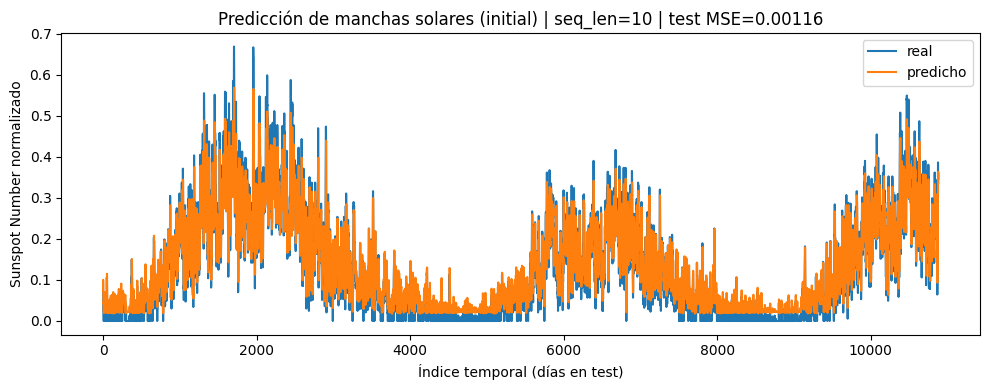

Epoch 10/50 | train MSE=0.016038 | val MSE=0.025729 | grad_norm=0.138
Epoch 20/50 | train MSE=0.011852 | val MSE=0.008575 | grad_norm=0.208
Epoch 30/50 | train MSE=0.003714 | val MSE=0.003210 | grad_norm=0.071
Epoch 40/50 | train MSE=0.003677 | val MSE=0.002913 | grad_norm=0.115
Epoch 50/50 | train MSE=0.002734 | val MSE=0.001850 | grad_norm=0.055
Predicción de manchas solares (small) | seq_len=5 | tiempo_entrenamiento=0.70s | test MSE=0.001200


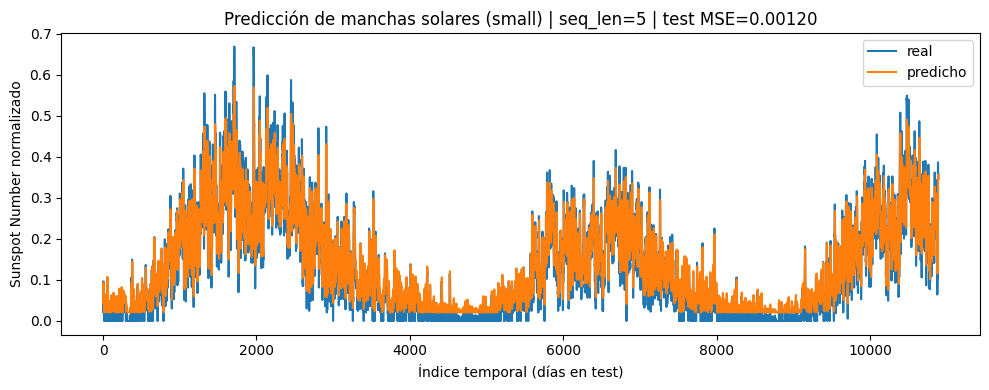

Epoch 10/50 | train MSE=0.017810 | val MSE=0.019142 | grad_norm=0.230
Epoch 20/50 | train MSE=0.006710 | val MSE=0.008468 | grad_norm=0.145
Epoch 30/50 | train MSE=0.004200 | val MSE=0.003023 | grad_norm=0.164
Epoch 40/50 | train MSE=0.002917 | val MSE=0.002007 | grad_norm=0.070
Epoch 50/50 | train MSE=0.002693 | val MSE=0.001844 | grad_norm=0.040
Predicción de manchas solares (medium) | seq_len=20 | tiempo_entrenamiento=2.89s | test MSE=0.001076


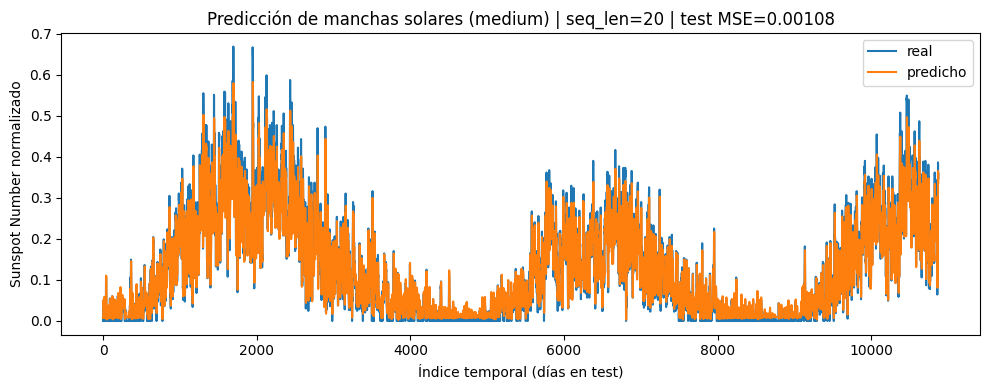

Epoch 10/50 | train MSE=0.026332 | val MSE=0.023477 | grad_norm=0.236
Epoch 20/50 | train MSE=0.022569 | val MSE=0.029940 | grad_norm=0.170
Epoch 30/50 | train MSE=0.017583 | val MSE=0.017171 | grad_norm=0.112
Epoch 40/50 | train MSE=0.013497 | val MSE=0.016796 | grad_norm=0.058
Epoch 50/50 | train MSE=0.008931 | val MSE=0.008487 | grad_norm=0.057
Predicción de manchas solares (large) | seq_len=100 | tiempo_entrenamiento=15.23s | test MSE=0.006062


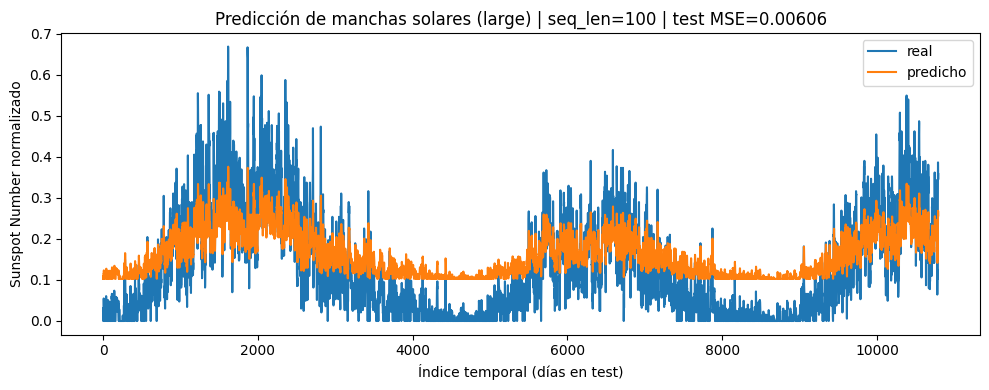

In [76]:
def runExperiment(seq_length, title):
    # Preparar datos según tamaño de ventana
    (Xtr, ytr), (Xva, yva), (Xte, yte) = makeSplitsForSeq(train_df, val_df, test_df, seq_length)

    # Definir modelo
    model = RnnModel(input_size=1, hidden_size=HIDDEN_SIZE, output_size=1)

    # Entrenar y obtener historial + tiempo de entrenamiento
    history, train_time = trainOneSplit(model, Xtr, ytr, Xva, yva, epochs=EPOCHS, lr=LR)

    # Evaluar en test
    preds, target, mse = evaluateModel(model, Xte, yte)
    print(f"{title} | seq_len={seq_length} | tiempo_entrenamiento={train_time:.2f}s | test MSE={mse:.6f}")

    # Gráfica de resultados
    plt.figure(figsize=(10,4))
    plt.plot(target, label="real")
    plt.plot(preds, label="predicho")
    plt.title(f"{title} | seq_len={seq_length} | test MSE={mse:.5f}")
    plt.xlabel("Índice temporal (días en test)")
    plt.ylabel("Sunspot Number normalizado")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return history, mse, train_time

for tag, slen in WINDOWS.items():
    runExperiment(slen, f"Predicción de manchas solares ({tag})")


## Resultados

Se puede inferir que entre más n valor de ventanas hay, el modelo no se va acoplando con el modelo real como se observa en la gráfica de 100 ventanas y 20 ventanas.  

## Referencias

- [RNN Documentation (PyTorch)](https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- [LSTM Documentation (PyTorch)](https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
- [Dataset Sunspots (WDC-SILSO)](https://www.sidc.be/SILSO/datafiles)
- [Información detallada del dataset diario (SILSO)](https://www.sidc.be/SILSO/infosndtot)